In [2]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import joblib
from sklearn.utils import class_weight
from sklearn.utils.class_weight import compute_class_weight
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
import xgboost as xgb
import os


Mounted at /content/drive


Starting Drought Prediction Pipeline for Multiple Grids...
Data loaded successfully with 109534 rows and 11 columns
Processing grid 1163: Aggregating to monthly data...
Processing grid 1164: Aggregating to monthly data...
Processing grid 1165: Aggregating to monthly data...
Processing grid 1166: Aggregating to monthly data...
Processing grid 1181: Aggregating to monthly data...
Processing grid 1182: Aggregating to monthly data...
Processing grid 1183: Aggregating to monthly data...
Processing grid 1184: Aggregating to monthly data...
Processing grid 1198: Aggregating to monthly data...
Processing grid 1199: Aggregating to monthly data...
Processing grid 1200: Aggregating to monthly data...
Processing grid 1201: Aggregating to monthly data...

Engineered Features:
['date', 'temperature_2m_max', 'temperature_2m_min', 'temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_gusts_10m_max', 'wind_direction_10m_dominant', 'shortwave_radiation_sum', 'et0_fao_evapotranspiration

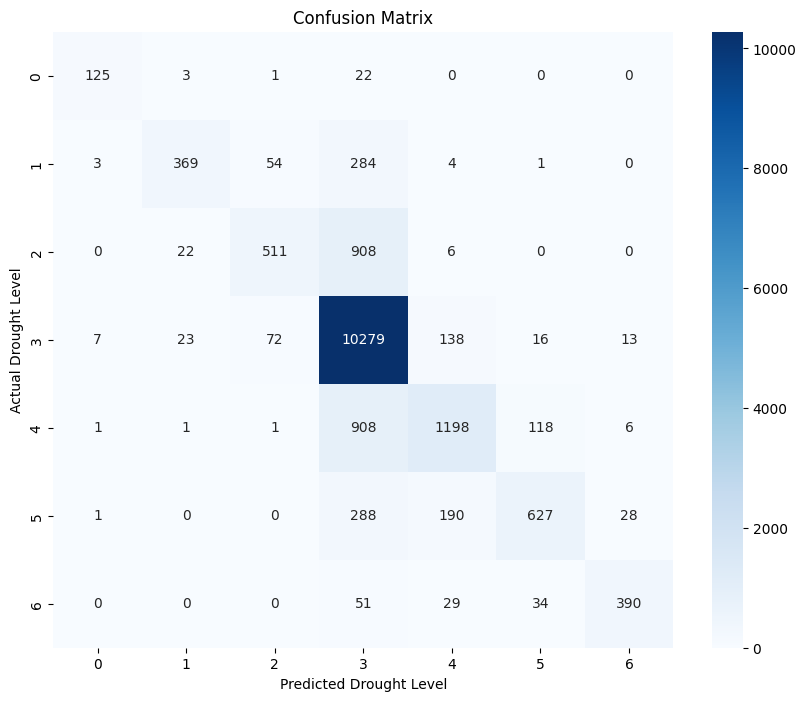


Pipeline execution completed.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import xgboost as xgb
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
# ----------------------
# 1. Load and prepare data (modified)
# ----------------------

def load_data(filepath='/content/drive/MyDrive/FYP/processed_data/punjab_lahore_data.csv'):
    """
    Load climate data for all Karachi grids
    """
    try:
        df = pd.read_csv(filepath)

        print(f"Data loaded successfully with {df.shape[0]} rows and {df.shape[1]} columns")
        return df
    except FileNotFoundError:
        print("File not found. Please provide the correct path to your data.")
        return None


# ----------------------
# 2. Calculate SPI and define drought levels (modified)
# ----------------------
def calculate_spi(df, periods=[1, 3, 6, 12], base_column='precipitation_sum'):
    """
    Calculate Standardized Precipitation Index (SPI) for different time scales
    Now calculates SPI separately for each grid
    """
    if df is None:
        return None

    # Convert date to datetime if it's not already
    if not pd.api.types.is_datetime64_any_dtype(df['date']):
        df['date'] = pd.to_datetime(df['date'])

    # Create a copy to avoid modifying the original DataFrame
    df_spi = df.copy()

    # Group data by grid, year, and month for monthly aggregation
    df_spi['year'] = df_spi['date'].dt.year
    df_spi['month'] = df_spi['date'].dt.month

    # We'll store the final results here
    final_dfs = []

    # Calculate SPI separately for each grid
    for grid_id in df_spi['grid_id'].unique():
        grid_data = df_spi[df_spi['grid_id'] == grid_id].copy()

        # Aggregate to monthly data if the input is daily
        if len(grid_data) > 12 * 24:  # If we have more than 24 years of data, assume it's daily
            print(f"Processing grid {grid_id}: Aggregating to monthly data...")
            monthly_data = grid_data.groupby(['year', 'month'])[base_column].sum().reset_index()

            # Convert back to datetime format for time series operations
            monthly_data['date'] = pd.to_datetime(monthly_data[['year', 'month']].assign(day=1))
            monthly_data = monthly_data.sort_values('date')
        else:
            # Data is already monthly
            monthly_data = grid_data[['year', 'month', 'date', base_column]].copy()

        # Calculate SPI for each period
        for period in periods:
            # Create column name for this SPI period
            col_name = f'SPI_{period}'

            # Create rolling sum for the period
            rolling_sum = monthly_data[base_column].rolling(window=period, min_periods=period).sum()

            # For each month, collect all historic values for this month and the rolling sum
            spi_values = []

            for i in range(len(monthly_data)):
                # Skip if we don't have enough data for the rolling window
                if i < period - 1:
                    spi_values.append(np.nan)
                    continue

                current_month = monthly_data['month'].iloc[i]

                # Get historical values for the same month
                historical_values = []
                for j in range(i, -1, -period):
                    if monthly_data['month'].iloc[j] == current_month:
                        historical_values.append(rolling_sum.iloc[j])

                # Calculate SPI using gamma distribution
                if len(historical_values) >= 3:  # Need at least a few values for the distribution
                    # Avoid zeros by adding a small constant
                    historical_array = np.array(historical_values) + 0.01

                    try:
                        # Fit a gamma distribution to the historical data
                        shape, loc, scale = stats.gamma.fit(historical_array, floc=0)

                        # Calculate the cumulative probability of the current value
                        current_value = rolling_sum.iloc[i] + 0.01
                        cdf = stats.gamma.cdf(current_value, shape, loc=loc, scale=scale)

                        # Convert to standard normal distribution (SPI)
                        spi = stats.norm.ppf(cdf)

                        # Handle any infinities
                        if np.isinf(spi):
                            if spi > 0:
                                spi = 3.0  # Cap at 3 for extremely wet
                            else:
                                spi = -3.0  # Cap at -3 for extremely dry
                    except:
                        # If there's an error fitting the distribution, use a simpler approach
                        mean = np.mean(historical_array)
                        std = np.std(historical_array)
                        if std == 0:
                            spi = 0
                        else:
                            spi = (current_value - mean) / std
                else:
                    spi = np.nan

                spi_values.append(spi)

            # Add SPI values to the DataFrame
            monthly_data[col_name] = spi_values

        # Define drought levels based on SPI values
        for period in periods:
            spi_col = f'SPI_{period}'
            drought_level_col = f'drought_level_{period}'

            def classify_drought(spi):
                if pd.isna(spi):
                    return np.nan
                elif spi > 2.0:
                    return 6  # Extremely wet
                elif spi > 1.5:
                    return 5  # Very wet
                elif spi > 1.0:
                    return 4  # Moderately wet
                elif spi > -1.0:
                    return 3  # Near normal
                elif spi > -1.5:
                    return 2  # Moderately dry
                elif spi > -2.0:
                    return 1  # Severely dry
                else:
                    return 0  # Extremely dry

            monthly_data[drought_level_col] = monthly_data[spi_col].apply(classify_drought)

        # Merge back with original data
        if len(grid_data) > len(monthly_data):
            # If original data is daily, merge based on year and month
            merged_data = grid_data.merge(
                monthly_data.drop(columns=[base_column]),
                on=['year', 'month'],
                how='left',
                suffixes=('', '_y')
            )
        else:
            merged_data = monthly_data

        # Add back the grid_id
        merged_data['grid_id'] = grid_id
        final_dfs.append(merged_data)

    # Combine all grids
    df_spi_combined = pd.concat(final_dfs, ignore_index=True)

    return df_spi_combined


# ----------------------
# 3. Feature Engineering (modified)
# ----------------------
def engineer_features(df):
    """
    Create derived features from the raw climate data
    Now includes grid_id as a feature
    """
    if df is None:
        return None

    # Convert date to datetime
    df['date'] = pd.to_datetime(df['date'])

    # Extract date features
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day if 'day' not in df.columns else df['day']
    df['dayofyear'] = df['date'].dt.dayofyear

    # Create a season feature
    df['season'] = df['month'].apply(lambda month:
                                    'Winter' if month in [12, 1, 2] else
                                    'Spring' if month in [3, 4, 5] else
                                    'Summer' if month in [6, 7, 8] else
                                    'Fall')

    # Encode season
    season_mapping = {'Winter': 0, 'Spring': 1, 'Summer': 2, 'Fall': 3}
    df['season_encoded'] = df['season'].map(season_mapping)

    # Calculate temperature range
    df['temperature_range'] = df['temperature_2m_max'] - df['temperature_2m_min']

    # Calculate rolling statistics for precipitation - now grouped by grid
    df['precipitation_30d_sum'] = df.groupby('grid_id')['precipitation_sum'].transform(
        lambda x: x.rolling(window=30, min_periods=1).sum()
    )
    df['precipitation_60d_sum'] = df.groupby('grid_id')['precipitation_sum'].transform(
        lambda x: x.rolling(window=60, min_periods=1).sum()
    )
    df['precipitation_90d_sum'] = df.groupby('grid_id')['precipitation_sum'].transform(
        lambda x: x.rolling(window=90, min_periods=1).sum()
    )

    # Calculate dry days
    drought_threshold = 1.0  # 1mm of precipitation
    df['is_dry_day'] = (df['precipitation_sum'] < drought_threshold).astype(int)
    df['dry_days_30d'] = df.groupby('grid_id')['is_dry_day'].transform(
        lambda x: x.rolling(window=30, min_periods=1).sum()
    )

    # Calculate other features
    df['aridity_index'] = df['et0_fao_evapotranspiration'] / (df['precipitation_sum'].replace(0, 0.1))
    df['water_balance'] = df['precipitation_sum'] - df['et0_fao_evapotranspiration']
    df['water_balance_30d'] = df.groupby('grid_id')['water_balance'].transform(
        lambda x: x.rolling(window=30, min_periods=1).sum()
    )

    # Handle direction as a cyclical feature
    if 'wind_direction_10m_dominant' in df.columns:
        wind_dir_rad = np.radians(df['wind_direction_10m_dominant'])
        df['wind_direction_sin'] = np.sin(wind_dir_rad)
        df['wind_direction_cos'] = np.cos(wind_dir_rad)

    # Add grid_id to features
    df['grid_id'] = df['grid_id'].astype('category')

    print("\nEngineered Features:")
    print(df.columns.tolist())

    return df


# ----------------------
# 4. Data preprocessing and EDA (modified)
# ----------------------
def preprocess_data(df, target_column='drought_level_3'):
    """
    Preprocess data for multiple grids
    """
    if df is None:
        return None, None, None, None, None

    # Select features for the model - now includes grid_id
    engineered_features = [
        'grid_id',  # Added grid_id as a feature
        'temperature_2m_max', 'temperature_2m_min', 'temperature_2m_mean',
        'precipitation_sum', 'wind_speed_10m_max', 'wind_gusts_10m_max',
        'shortwave_radiation_sum', 'et0_fao_evapotranspiration', 'month',
        'season_encoded', 'temperature_range', 'precipitation_30d_sum',
        'precipitation_60d_sum', 'precipitation_90d_sum',
        'dry_days_30d', 'aridity_index', 'water_balance', 'water_balance_30d'
    ]

    # Add wind direction features if available
    if 'wind_direction_sin' in df.columns and 'wind_direction_cos' in df.columns:
        engineered_features.extend(['wind_direction_sin', 'wind_direction_cos'])

    # Handle missing values
    df = df.dropna(subset=[target_column])
    df = df.fillna(method='ffill')

    # Create preprocessing pipeline
    numeric_features = [f for f in engineered_features if f != 'grid_id']
    numeric_transformer = Pipeline(steps=[
        ('scaler', StandardScaler())
    ])

    categorical_features = ['grid_id']
    categorical_transformer = Pipeline(steps=[
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ])

    # Create feature matrix and target
    X = df[engineered_features]
    y = df[target_column]

    # Split the data - stratify by both target and grid_id
    df_train, df_test = train_test_split(
        df,
        test_size=0.2,
        random_state=42,
        stratify=df[[target_column, 'grid_id']]
    )

    X_train = df_train[engineered_features]
    y_train = df_train[target_column]
    X_test = df_test[engineered_features]
    y_test = df_test[target_column]

    # Fit the preprocessor on training data
    X_train_processed = preprocessor.fit_transform(X_train)
    X_test_processed = preprocessor.transform(X_test)

    print(f"\nTraining set size: {X_train.shape}")
    print(f"Testing set size: {X_test.shape}")

    return X_train_processed, X_test_processed, y_train, y_test, preprocessor, engineered_features

# ----------------------
# 5. Train and tune XGBoost model
# ----------------------
def train_xgboost(X_train, y_train, engineered_features=None,preprocessor=None):
    """
    Train and tune XGBoost model for multi-class drought level prediction
    """
    if X_train is None or y_train is None:
        return None

    print("\nTraining XGBoost model for drought level prediction...")

    # Check number of classes
    n_classes = len(np.unique(y_train))
    print(f"Number of drought level classes: {n_classes}")

    # Initial model with default parameters
    if n_classes > 2:
        # Multi-class classification
        xgb_model = xgb.XGBClassifier(
            objective='multi:softmax',
            num_class=n_classes,
            random_state=42,
            use_label_encoder=False,
            eval_metric='mlogloss'
        )
    else:
        # Binary classification
        xgb_model = xgb.XGBClassifier(
            objective='binary:logistic',
            random_state=42,
            use_label_encoder=False,
            eval_metric='logloss'
        )

    # Cross-validation to evaluate baseline model
    cv_scores = cross_val_score(xgb_model, X_train, y_train, cv=5, scoring='accuracy')
    print(f"Baseline Cross-Validation Accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

    # Hyperparameter tuning with GridSearchCV
    print("\nPerforming hyperparameter tuning...")
    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0]
    }

    # For demonstration purposes, use a smaller grid
    small_param_grid = {
        'n_estimators': [100],
        'max_depth': [5],
        'learning_rate': [0.1],
    }

    grid_search = GridSearchCV(
        estimator=xgb_model,
        param_grid=small_param_grid,  # Use small_param_grid for quick execution, param_grid for thorough tuning
        scoring='accuracy',
        cv=5,
        verbose=1
    )

    grid_search.fit(X_train, y_train)

    print(f"\nBest parameters: {grid_search.best_params_}")
    print(f"Best cross-validation accuracy: {grid_search.best_score_:.4f}")

    # Train final model with best parameters
    best_xgb_model = grid_search.best_estimator_
    best_xgb_model.fit(X_train, y_train)


        # Get feature importance
    importance = best_xgb_model.feature_importances_

    # Function to extract feature names from preprocessor
    def get_feature_names(preprocessor):
        feature_names = []
        for name, transformer, features in preprocessor.transformers_:
            if transformer == 'drop':
                continue
            elif transformer == 'passthrough':
                feature_names.extend(features)
            elif hasattr(transformer, 'get_feature_names_out'):
                try:
                    names = transformer.get_feature_names_out(features)
                except:
                    names = transformer.get_feature_names_out()
                feature_names.extend(names)
            else:
                feature_names.extend(features)
        return feature_names

        # Get the actual feature names after preprocessing
        if preprocessor is not None:
            all_features = get_feature_names(preprocessor)
        else:
            all_features = engineered_features if engineered_features is not None else []

        # Debugging: Check if lengths match
        print(f"\nLength of all_features: {len(all_features)}")
        print(f"Length of importance: {len(importance)}")

        # Create feature importance DataFrame (safely)
        min_len = min(len(all_features), len(importance))
        feature_importance = pd.DataFrame({
            'Feature': all_features[:min_len],
            'Importance': importance[:min_len]
        }).sort_values('Importance', ascending=False)

        print("\nTop 10 Feature Importances:")
        print(feature_importance.head(10))


        # Plot feature importance
        plt.figure(figsize=(12, 8))
        sns.barplot(x='Importance', y='Feature', data=feature_importance)
        plt.title('XGBoost Feature Importance for Drought Level Prediction')
        plt.tight_layout()
        plt.savefig('feature_importance.png')
        plt.close()

        print("\nTop 10 Features:")
        print(feature_importance.head(10))


    return best_xgb_model

# ----------------------
# 6. Evaluate model
# ----------------------
def evaluate_model(model, X_test, y_test):
    """
    Evaluate the trained model for drought level prediction
    """
    if model is None or X_test is None or y_test is None:
        return

    print("\nEvaluating model on test set...")
    y_pred = model.predict(X_test)

    # Accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Test Accuracy: {accuracy:.4f}")

    # Classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('Actual Drought Level')
    plt.xlabel('Predicted Drought Level')
    plt.savefig('confusion_matrix.png')
    plt.show()
    plt.close()

    # Create a more detailed confusion matrix with labels
    drought_levels = {
        0: "Extremely Dry",
        1: "Severely Dry",
        2: "Moderately Dry",
        3: "Mild Drought",
        4: "Moderately Wet",
        5: "Very Wet",
        6: "Extremely Wet"
    }

    # Get unique classes from both actual and predicted
    all_classes = np.unique(np.concatenate([y_test, y_pred]))

    # Create a DataFrame for the confusion matrix with labels
    cm_df = pd.DataFrame(cm,
                       index=[drought_levels.get(i, f"Level {i}") for i in sorted(all_classes)],
                       columns=[drought_levels.get(i, f"Level {i}") for i in sorted(all_classes)])

    plt.figure(figsize=(12, 10))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
    plt.title('Labeled Confusion Matrix')
    plt.ylabel('Actual Drought Level')
    plt.xlabel('Predicted Drought Level')
    plt.tight_layout()
    plt.savefig('labeled_confusion_matrix.png')
    plt.close()

# ----------------------
# 7. Save model and prediction function
# ----------------------
def save_model(model, preprocessor=None, engineered_features=None, spi_periods=None):
    """
    Save the trained model and related components for future use
    """
    if model is None:
        return

    print("\nSaving model and components...")

    # Save model
    model.save_model('/content/drive/MyDrive/FYP/processed_data/drought_prediction_model_lahore(all).json')

    # Save preprocessor and feature list
    if preprocessor is not None or engineered_features is not None or spi_periods is not None:
        import joblib
        components = {
            'preprocessor': preprocessor,
            'engineered_features': engineered_features,
            'spi_periods': spi_periods
        }
        joblib.dump(components, '/content/drive/MyDrive/FYP//processed_data/model_components_lahore(all).joblib')

    print("Model and components saved successfully.")
# ----------------------
# 8. Prediction Function for New Data (modified)
# ----------------------
def predict_drought_from_forecast(forecast_data,  model_path='/content/drive/MyDrive/FYP//processed_data/drought_prediction_model_lahore(all).json', components_path='/content/drive/MyDrive/FYP//processed_data/model_components_lahore(all).joblib'):
    """
    Predict drought level from forecast data for multiple grids
    """
    import joblib

    # Load model and components
    model = xgb.XGBClassifier()
    model.load_model(model_path)

    components = joblib.load(components_path)
    preprocessor = components['preprocessor']
    engineered_features = components['engineered_features']

    # Convert forecast data to DataFrame
    if isinstance(forecast_data, dict):
        forecast_df = pd.DataFrame([forecast_data])
    else:
        forecast_df = forecast_data.copy()

    # Ensure grid_id is present
    if 'grid_id' not in forecast_df.columns:
        raise ValueError("grid_id must be provided in forecast data")

    # Engineer features for the forecast data
    # Engineer features for the forecast data
    for feature in engineered_features:
        if feature not in forecast_df.columns:
            if feature == 'season_encoded':
                # Calculate season from month
                if 'month' in forecast_df.columns:
                    month = forecast_df['month'].iloc[0]
                    season = 0 if month in [12, 1, 2] else 1 if month in [3, 4, 5] else 2 if month in [6, 7, 8] else 3
                    forecast_df['season_encoded'] = season
                else:
                    forecast_df['season_encoded'] = 0  # Default to winter if month not provided

            elif feature == 'temperature_range':
                if 'temperature_2m_max' in forecast_df.columns and 'temperature_2m_min' in forecast_df.columns:
                    forecast_df['temperature_range'] = forecast_df['temperature_2m_max'] - forecast_df['temperature_2m_min']
                else:
                    forecast_df['temperature_range'] = 0  # Default value

            elif feature == 'wind_direction_sin':
                if 'wind_direction_10m_dominant' in forecast_df.columns:
                    forecast_df['wind_direction_sin'] = np.sin(np.radians(forecast_df['wind_direction_10m_dominant']))
                else:
                    forecast_df['wind_direction_sin'] = 0  # Default value

            elif feature == 'wind_direction_cos':
                if 'wind_direction_10m_dominant' in forecast_df.columns:
                    forecast_df['wind_direction_cos'] = np.cos(np.radians(forecast_df['wind_direction_10m_dominant']))
                else:
                    forecast_df['wind_direction_cos'] = 1  # Default value

            elif feature in ['precipitation_30d_sum', 'precipitation_60d_sum', 'precipitation_90d_sum']:
                # Use the current precipitation as a proxy if historical data isn't available
                if 'precipitation_sum' in forecast_df.columns:
                    forecast_df[feature] = forecast_df['precipitation_sum'] * 30  # Approximate for a month
                else:
                    forecast_df[feature] = 0  # Default value

            elif feature == 'dry_days_30d':
                if 'precipitation_sum' in forecast_df.columns:
                    forecast_df['dry_days_30d'] = (forecast_df['precipitation_sum'] < 1.0).astype(int) * 30  # Approximate
                else:
                    forecast_df['dry_days_30d'] = 15  # Default middle value

            elif feature == 'aridity_index':
                if 'et0_fao_evapotranspiration' in forecast_df.columns and 'precipitation_sum' in forecast_df.columns:
                    forecast_df['aridity_index'] = forecast_df['et0_fao_evapotranspiration'] / forecast_df['precipitation_sum'].replace(0, 0.1)
                else:
                    forecast_df['aridity_index'] = 1.0  # Default value

            elif feature == 'water_balance':
                if 'precipitation_sum' in forecast_df.columns and 'et0_fao_evapotranspiration' in forecast_df.columns:
                    forecast_df['water_balance'] = forecast_df['precipitation_sum'] - forecast_df['et0_fao_evapotranspiration']
                else:
                    forecast_df['water_balance'] = 0  # Default value

            elif feature == 'water_balance_30d':
                if 'water_balance' in forecast_df.columns:
                    forecast_df['water_balance_30d'] = forecast_df['water_balance'] * 30  # Approximate for a month
                elif 'precipitation_sum' in forecast_df.columns and 'et0_fao_evapotranspiration' in forecast_df.columns:
                    forecast_df['water_balance_30d'] = (forecast_df['precipitation_sum'] - forecast_df['et0_fao_evapotranspiration']) * 30
                else:
                    forecast_df['water_balance_30d'] = 0  # Default value

            else:
                # For any other missing features, set to 0 or mean value
                forecast_df[feature] = 0


    # Select and order features to match the model's expectations
    X_forecast = forecast_df[engineered_features]

    # Preprocess the data
    X_forecast_processed = preprocessor.transform(X_forecast)

    # Make prediction
    drought_level = model.predict(X_forecast_processed)[0]

     # Get probabilities
    probabilities = model.predict_proba(X_forecast_processed)[0]

    # Map numeric drought level to category
    drought_categories = {
        0: "Extreme Drought ",
        1: "Severely Dry",
        2: "Moderately Dry",
        3: "Near Normal",
        4: "Moderately Wet",
        5: "Very Wet",
        6: "Extremely Wet"
    }

    drought_category = drought_categories.get(drought_level, f"Level {drought_level}")

    # Format class probabilities
    class_labels = [drought_categories.get(i, f"Level {i}") for i in model.classes_]
    probability_dict = {class_labels[i]: float(probabilities[i]) for i in range(len(class_labels))}

    # Return prediction results
    results = {
        'drought_level_numeric': int(drought_level),
        'drought_category': drought_category,
        'confidence': float(max(probabilities)),
        'class_probabilities': probability_dict
    }

    return results



def example_forecast_prediction(df):
    """
    Example of how to use the prediction function with forecast data
    """
    # Sample forecast data for a month
    forecast_data = df

    # Make prediction
    prediction = predict_drought_from_forecast(forecast_data)

    print("Forecast Prediction Results:")
    print(f"Predicted Drought Level: {prediction['drought_category']}")
    print(f"Confidence: {prediction['confidence'] * 100:.2f}%")
    print("\nClass Probabilities:")
    for cls, prob in prediction['class_probabilities'].items():
      print(f"{cls}: {prob * 100:.2f}%")
    print('')


    pass

# Main execution would remain similar
def main():
    print("Starting Drought Prediction Pipeline for Multiple Grids...")

    # 1. Load data (now loads all grids)
    df = load_data()
    if df is None:
        return

    # 2. Calculate SPI and drought levels (now per grid)
    spi_periods = [1, 3, 6, 12]
    df_spi = calculate_spi(df, periods=spi_periods)

    # 3. Feature engineering (now includes grid features)
    df_engineered = engineer_features(df_spi)

    # 4. Preprocess data
    X_train, X_test, y_train, y_test, preprocessor, engineered_features = preprocess_data(
        df_engineered,
        target_column='drought_level_3'
    )

     # 5. Train XGBoost model
    model = train_xgboost(X_train, y_train, engineered_features)

    # 6. Evaluate model
    evaluate_model(model, X_test, y_test)

    # 7. Save model and components
    #save_model(model, preprocessor, engineered_features, spi_periods)

    # 8. Example prediction
   # example_forecast_prediction()

    print("\nPipeline execution completed.")

if __name__ == "__main__":
   main()

In [ ]:
#df=pd.read_parquet("/content/drive/MyDrive/FYP/processed_data/punjab_merged.parquet")
start_date = "2024-07-01"
end_date = '2024-08-01'
pdf = df[(df['date'] >= start_date) & (df['date'] <= end_date) & (df['grid_id'] == 1198) ]

example_forecast_prediction(pdf)

Forecast Prediction Results:
Predicted Drought Level: Near Normal
Confidence: 59.12%

Class Probabilities:
Extreme Drought : 0.04%
Severely Dry: 0.98%
Moderately Dry: 0.90%
Near Normal: 59.12%
Moderately Wet: 38.82%
Very Wet: 0.08%
Extremely Wet: 0.06%



In [ ]:
from geopy.distance import geodesic
grid_data = pd.read_csv('/content/drive/MyDrive/FYP/fresh data/grid_maker/punjab_grid_points.csv')
grid_data.rename(columns=lambda x: x.strip().lower(), inplace=True)
if 'grid_id' not in grid_data.columns:
    grid_data.rename(columns={'Grid_ID': 'grid_id'}, inplace=True)

# Find nearest grid
def find_nearest_grid(lat, lon, grid_data):
    min_distance = float('inf')
    nearest_grid_id = None
    for _, row in grid_data.iterrows():
        distance = geodesic((lat, lon), (row['lat'], row['lon'])).km
        if distance < min_distance:
            min_distance = distance
            nearest_grid_id = row['grid_id']
    return int(nearest_grid_id)

## Filter and Map grids

In [ ]:
import pandas as pd

# Load the CSV
df = pd.read_csv('/content/drive/MyDrive/FYP/fresh data/grid_maker/punjab_grid_points.csv')

# Define bounding box for Lahore
min_lat, max_lat = 31.3, 31.7
min_lon, max_lon = 74.1, 74.5

# Filter for Lahore grids
lahore_df = df[
    (df['lat'] >= min_lat) & (df['lat'] <= max_lat) &
    (df['lon'] >= min_lon) & (df['lon'] <= max_lon)
]

# Save to new CSV if needed
#lahore_df.to_csv("lahore_grids.csv", index=False)
lahore_df.to_csv("/content/drive/MyDrive/FYP/fresh data/grid_maker/lahore_grids.csv", index=False)

import pandas as pd
import folium

# Load the filtered Lahore grid data
lahore_df = pd.read_csv("/content/drive/MyDrive/FYP/fresh data/grid_maker/punjab_grid_points.csv")

# Center map around average location of Lahore grids
map_center = [lahore_df['lat'].mean(), lahore_df['lon'].mean()]
m = folium.Map(location=map_center, zoom_start=11)

# Add grid points as markers (or circles)
for _, row in lahore_df.iterrows():
    folium.CircleMarker(
        location=[row['lat'], row['lon']],
        radius=4,
        color='blue',
        fill=True,
        fill_opacity=0.6,
        popup=f"Grid ID: {row['Grid_ID']}"
    ).add_to(m)

# Save to HTML and open in browser
m.save("/content/drive/MyDrive/FYP/fresh data/grid_maker/punjab_grids_map.html")

# Load Punjab full dataset
punjab_df = pd.read_parquet("/content/drive/MyDrive/FYP/processed_data/punjab_merged.parquet")

# List of Lahore Grid_IDs
lahore_grid_ids = [
    1163, 1164, 1165, 1166,
    1181, 1182, 1183, 1184,
    1198, 1199, 1200, 1201
]

# Filter rows with Grid_IDs matching Lahore
lahore_data = punjab_df[punjab_df["grid_id"].isin(lahore_grid_ids)]

# Save to CSV (optional)
lahore_data.to_csv("/content/drive/MyDrive/FYP/processed_data/punjab_lahore_data.csv", index=False)


,lat,lon,Grid_ID
0,31.33810,74.16970,1163
1,31.45312,74.16970,1164
2,31.56800,74.16970,1165
3,31.68274,74.16970,1166
4,31.33810,74.30445,1181
5,31.45312,74.30445,1182
6,31.56800,74.30445,1183
7,31.68274,74.30445,1184
8,31.33810,74.43920,1198
9,31.45312,74.43920,1199
